## 実習の事前準備

In [3]:
# 必要なライブラリのimport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# DataFrameですべての列を表示する設定
pd.options.display.max_columns = None

# seabornによる装飾を有効にする
sns.set_theme()

このレッスンでも、scikit-learnに含まれている Iris データセットを使用します。

In [4]:
# Irisデータセットの読み込み
from sklearn.datasets import load_iris
iris = load_iris()

以降で扱いやすいよう、DataFrame型へ変換しておきます。アヤメの品種は「species」という列名で追加しています。

In [5]:
# irisのfeature_namesは「sepal length(cm)」のように空白やカッコが付いていて扱いづらいので以下の列名を使用する
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# datasetの作成
dataset = pd.DataFrame(data = iris['data'], columns = feature_names)
dataset['species'] = iris['target']
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


クラスタリングとは、データをグループに分ける手法です。まずはデータセットの petal_width と petal_length で散布図を作成してみましょう。

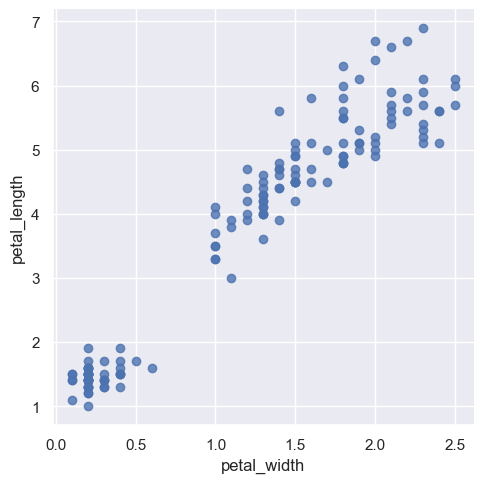

In [6]:
# petal_width と petal_length による散布図
sns.lmplot(x='petal_width', y='petal_length', data=dataset, fit_reg=False)

これを「3つ」に丸で囲ってなんとなくグループ化してみましょう（ここでは丸は割愛）

このグループ化をプログラムで行う手法が クラスタリング です。1つ1つのグループのことを クラスタ 、グループの数のことを クラスタ数 と呼びます。

## k-means法を使ってみよう

In [7]:
# KMeansのimport
from sklearn.cluster import KMeans

In [8]:
# データ（X）：petal_widthとpetal_length
X = np.array(dataset[['petal_width', 'petal_length']])

# 形状を確認
print("X=", X.shape)

X= (150, 2)


モデルを作成し fit() で学習を行うのはこれまでと同様です。パラメータの意味は以下のとおりです。

- n_clusters：クラスタの数
- init： k-means++でk-means++法、または randomでk-means法を指定
- n_init：異なるシードを使ってクラスタリングを繰り返す数


In [9]:
# クラスタ数を3としてモデルを作成
kmeans_model = KMeans(n_clusters=3, init='k-means++', n_init=10)
kmeans_model.fit(X)

KMeans(n_clusters=3, n_init=10)

predict() でクラスタ番号（予測値）を取得できます。 fit_predict で学習とクラスタ番号の取得をまとめて行うことも可能です。

In [10]:
# クラスタ番号（予測値）を取得
# （補足）kmeans_model.fit_predict(X)：fitとpredictをまとめて実施
Y_pred = kmeans_model.predict(X)
Y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

クラスタリングの結果と、アヤメの品種を比較してみましょう。

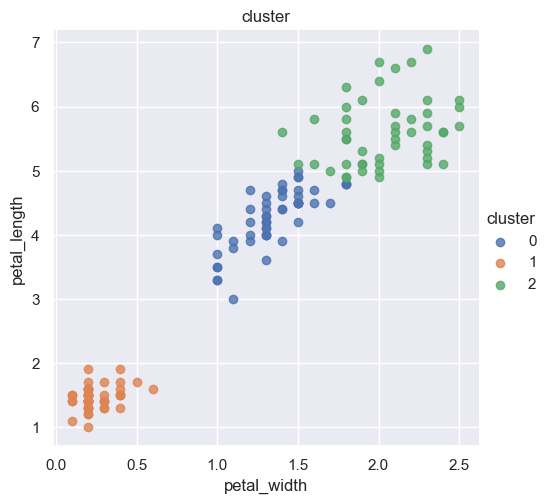

In [11]:
# グラフ化用DataFrameを作成して、tempに格納
temp = dataset[['petal_width', 'petal_length', 'species']].copy()
temp['cluster'] = kmeans_model.labels_

# k-means法によるクラスタリングの結果を描画
ax = sns.lmplot(x='petal_width', y='petal_length', data=temp, hue='cluster', fit_reg=False)
ax.set(title='cluster')

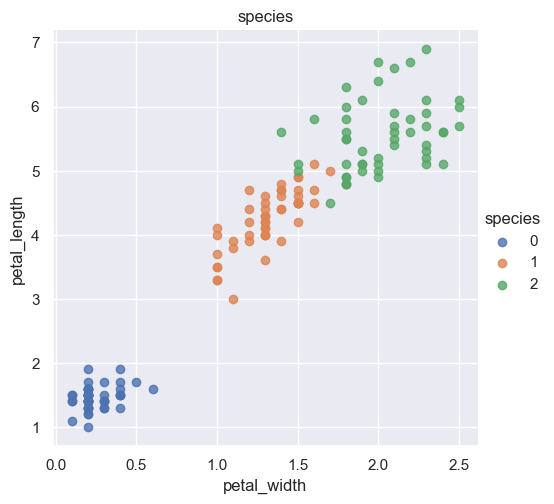

In [12]:
# アヤメの品種（正解）を描画
ax = sns.lmplot(x='petal_width', y='petal_length', data=temp, hue='species', fit_reg=False)
ax.set(title='species')

境目のところが若干違いますが、概ね、似たように分類されていることが確認できます。

## クラスタリングの評価

クラスタリングの評価基準には 凝集性（ぎょうしゅうせい、cohesion） と 分離性（ぶんりせい、separation） があります。

- 凝集性：各グループ内でデータの距離が近いこと。前述した WCSS（シードとデータとの距離の総和、Within-Cluster Sum of Squares）が小さいことを意味します
- 分離性：各クラスター同士が離れていること

### 凝集性（エルボーメソッドのグラフ）

はじめは 凝集性 に着目します。クラスタ数を変えながらWCSSをグラフで確認し、適切なクラスタ数を評価してみましょう。

モデルの inertia_ プロパティにWCSSが格納されています。

In [13]:
# 各クラスタごとのWCSSを格納するリスト
wcss = []

# クラスタ数のリスト（1から9)
c_list = np.arange(1, 10)

for c in c_list:
    # クラスタ数を c で指定
    kmeans_model = KMeans(n_clusters=c, init='k-means++', n_init=10)
    kmeans_model.fit(X)
    # inertia_プロパティに、WCSSが格納されている
    wcss.append(kmeans_model.inertia_)

In [14]:
# WCSSの表示
wcss

[550.8953333333333,
 86.39021984551397,
 31.371358974358973,
 19.483000899685113,
 13.91690875790876,
 11.025145110250373,
 9.203314009661835,
 7.624193062579723,
 6.456494541406307]

<Axes: >

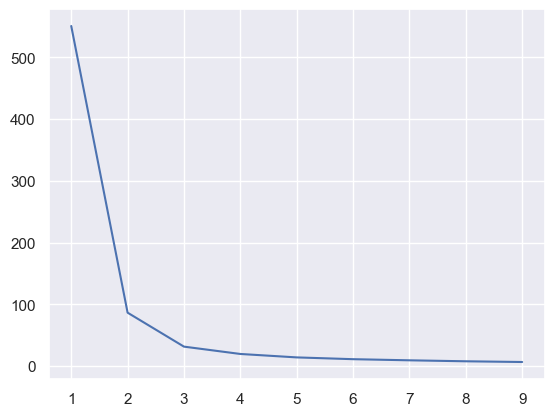

In [15]:
# グラフ化
sns.lineplot(x=c_list, y=wcss)

このグラフは肘のように見えることから エルボーメソッド (Elbow method)と呼ばれます。

- クラスタ数1～2：WCSSが大きい状態。十分にクラスタリングができていないことを示しています
- クラスタ数が5以上：クラスタ数を増やしても、WCSSの減少幅が小さくなります。このあたりから、クラスタ数を増やすことによる改善効果が薄れていると考えられます

よって、WCSSがこれ以上大きく下がらないクラスタ数3か4が「最適なクラスタ数」と読み取ることができます。

### 凝集性と分離性（シルエットプロットのグラフ）

凝集性と分離性の両方に着目したのが シルエットプロット です。シルエットプロットは シルエットスコア をグラフにしたものです。シルエットスコアは、クラスタに属するデータとシードとの距離を -1～1 の値の範囲で表したものです。1 に近いほど、自クラスタのシードに近く、-1 に近いほど、他のクラスタのシードに近い（自クラスタのシードからは遠い）と言えます。

シルエットスコアを計算するには scikit-learn の silhouette_score と silhouette_samples を使います。

In [16]:
# 必要なライブラリの追加import
from sklearn.metrics import silhouette_score, silhouette_samples

今回はクラスタ数＝3でクラスタリングを行ってみます。

In [17]:
# クラスタ数の指定
cluster_no = 3

# クラスタリング
kmeans_model = KMeans(n_clusters=cluster_no, init='k-means++', n_init=10)
Y_pred = kmeans_model.fit_predict(X)

シルエットスコアを計算します。

In [18]:
# シルエットスコアの平均値
s_average = silhouette_score(X, Y_pred)

# 各データのシルエットスコア
s_score = silhouette_samples(X, Y_pred, metric='euclidean')

参考サイトのソースコードを少し改修してシルエットプロットを描画します。ソースコードの内容は理解する必要がありません。
参照サイト：
　https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
　https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html
　https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

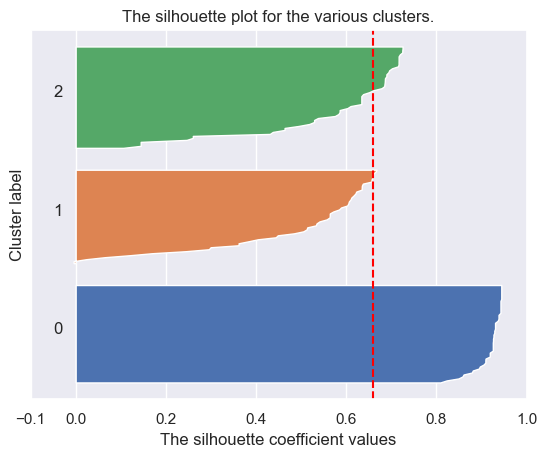

In [ ]:
# シルエットプロットを描画
# 参考： https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html


シルエットプロットは、シルエットスコアを横線で引いたものです。それぞれのナイフのような形は、各データのシルエットスコアの横線が集まったものです。このシルエットプロットから以下のようなことを判断します。

- 各シルエットがナイフのような形になっていれば、きれいにクラスタリングが行われていると判断できます
- クラスタ番号0のデータは、シルエットスコアが概ね1に近く、高い凝集性であることがわかります
- 各シルエットの厚さが同等であれば、各クラスタのデータ数も同等と判断できます
- クラスタ番号1をよく見ると、ごくわずかですがスコアがマイナスになっているデータがあります。このぐらいであれば問題ありませんが、マイナスが多いようであれば、クラスタ数の変更が必要と判断します

クラスタ数をいろいろと変えて、シルエットプロットの変化を確認してみましょう。

## 補足

### 混合ガウスモデル

k-means法でクラスタリングがうまく機能しない場合は 混合ガウスモデル の使用を検討しましょう。k-means法は「球状にあつまったクラスタ」に対しては有効ですが、歪んだクラスタがたがいに重なり合っているような場合は上手く機能しません。

混合ガウスモデル はk-means法と同様にユーザがクラスタ数を指定します。個々のクラスタがガウス分布という分布をしていると仮定して学習を行います。ガウス分布のクラスタが複数あるので「混合ガウスモデル」と呼ばれます。結果は各データごとの各クラスタに属する確率となります。具体的な計算式は難しいため、説明を省略します。


混合ガウスモデルは scikit-learn の GaussianMixture クラスを使います。

In [19]:
# GaussianMixtureのimport
from sklearn.mixture import GaussianMixture

混合ガウスモデルでもk-means法と同様のパラメータを指定できます。

n_components：クラスタの数
n_init：異なるシードを使ってクラスタリングを繰り返す数

In [20]:
# クラスタ数を3として混合ガウスモデルを作成
gaussian_model = GaussianMixture(n_components=3, n_init=10)
gaussian_model.fit(X)

GaussianMixture(n_components=3, n_init=10)

predict() でクラスタ番号を取得します。

In [23]:
# クラスタ番号を取得
Y_pred = gaussian_model.predict(X)
Y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

先ほどと同様、クラスタリングの結果と、アヤメの品種をグラフで比較してみましょう。

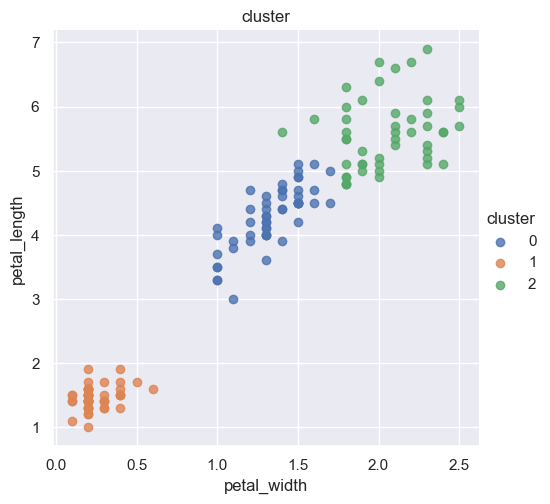

In [24]:
# グラフ化用DataFrameの作成
temp = dataset[['petal_width', 'petal_length', 'species']].copy()
temp['cluster'] = Y_pred

# 混合ガウスモデルによるクラスタリングの結果を描画
ax = sns.lmplot(x='petal_width', y='petal_length', data=temp, hue='cluster', fit_reg=False)
ax.set(title='cluster')

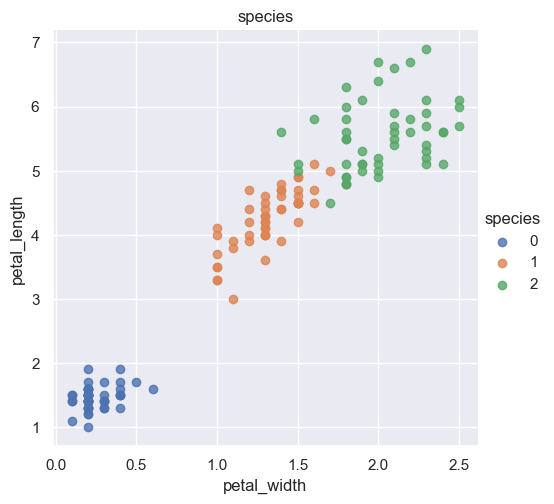

In [25]:
# アヤメの品種を描画
ax = sns.lmplot(x='petal_width', y='petal_length', data=temp, hue='species', fit_reg=False)
ax.set(title='species')

### 階層型クラスタリング

階層型クラスタリングは、ボトムアップでクラスタを作成するアルゴリズムです。

1. 各データ（ノード）間の距離を総当たりで調べる
2. もっとも距離が近いノードのペアをまとめて、1つのノード（クラスタ）と定義し直す。
3. 2でまとめられたノードを1つのノードと見て、その他のノードとの距離（リンケージと呼ばれる）を計算し直す。
4. すべてが1つのノードとしてまとまるまで、2と3を繰り返す。

階層型クラスタリングは、あらかじめクラスタ数を決める必要がないというメリットがあります。後述する樹形図（デンドログラム）を使い、クラスタリングの途中課程の任意の位置でクラスタ数を決めることができます

In [26]:
# 必要なライブラリの追加import
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage

総当たり距離の計算は、 scipy の pdist() 関数を使用します。距離の計算方法はデフォルトではユークリッド距離（euclidean）ですが、他のタイプの距離を用いることもできます。

In [27]:
# 総当り距離の計算
dists = pdist(X)
dists.shape

(11175,)

distsは、「condensed form」と呼ばれる上三角部分（+α）を1次元配列の形で保存した行列表現になっています。距離として確認するには、 scipy の squareform() メソッドを使用します。

In [28]:
# 150 X 150 の行列の形に変換
dists2 = squareform(dists)
dists2.shape

(150, 150)

距離をヒートマップで可視化してみましょう。

<Axes: >

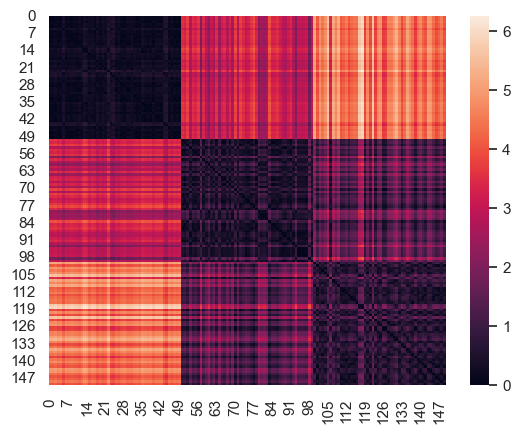

In [29]:
# ヒートマップによる可視化
sns.heatmap(dists2)

色が濃いほど距離が近いことを表します。もともとのデータは品種ごとに並んでいたため、それぞれの品種ごとに距離が近い、すなわちクラスタとしてまとまっていることがわかります。

階層型クラスタリングの実行

さて、距離が定義できたところで、クラスタリングを行います。階層型クラスタリングに対応する関数は、 scipy の linkage メソッドを使用します。

In [30]:
# 階層型クラスタリングの実行
Z = linkage(dists, 'ward')

第2引数（ここでは 'ward'）が、リンケージ（クラスタと別のノードとの距離）の計算アルゴリズムを表しています。他にも、第2引数で指定できるアルゴリズムがありますので、以下にまとめます。

- ward：
Ward’s minimum variance method と呼ばれる方法です。クラスタ内の「重心」を求め、重心と他のノードとの距離を計算します。他の方法と比較して、外れ値による影響が少ないため、多く用いられています
- single：
もっとも単純なアルゴリズムです。「クラスタ内のノードのうち、対象ノードにもっとも近いノードの距離」がクラスタと対象ノードとの距離として計算されます。ただしこの場合クラスタが大きくなればなるほど、「本来の」距離に関係なく他のノードがそのクラスタに追加されやすくなってしまうという問題点があり、あまり利用されません。
- average：
新しいクラスタの「中心」を構成ノードの内分点によって定義するものです。ただしこの方法は、クラスタ内の外れ値の影響で他のノードとの距離が、大きく算出される傾向があります。

では、クラスタリングの結果を確認しましょう。

In [31]:
# 0番目の組み合わせ
Z[0]

array([0., 1., 0., 2.])

結果は「どのノードとどのノードをクラスタにしたか」の情報です。最初の2つがノード番号、次がノード間の距離、最後ができ上がったクラスタのサイズです。上記の場合、ノード番号「0, 1」の距離が0で、クラスタのサイズは「2」という意味です。

ノード番号を表示すると以下のようになります。

In [32]:
# ノード番号の確認1
Z[:,0]

array([  0.,   4.,   2.,   3.,   8.,   6.,  10.,  28.,   9.,  27.,  11.,
        12.,  14.,  15.,  40.,  45.,  38.,  42.,  29.,  30.,  46.,  34.,
        39.,  48.,  31.,  33.,  47.,  49.,  57.,  60.,  53.,  89.,  88.,
        94.,  74.,  65.,  51.,  68.,  78.,  84.,  50.,  52.,  70., 138.,
       123., 101., 116., 136.,  55.,  62., 119., 110., 115., 112., 100.,
         5.,  69.,  58.,  85.,  18.,  56., 114.,  76., 146., 103.,  16.,
        95.,  19.,  92.,  54., 149.,  23.,  90.,  83., 132.,  80., 104.,
       125., 111.,  13., 158., 105., 193., 184., 162., 144., 182., 124.,
       121., 148., 165., 122., 143., 170., 108.,  24.,  73., 185.,  77.,
        43., 107.,  81.,  59., 102., 135., 210., 139., 173., 208., 220.,
       177., 191.,  61., 211., 234., 199., 246., 217.,  98.,  64., 118.,
       227., 247., 237., 134., 243., 229., 256., 252., 235., 258., 267.,
       232., 268., 250., 260., 254., 263., 272., 274., 281., 282., 278.,
       286., 270., 288., 291., 295., 290.])

In [34]:
# ノード番号の確認2
Z[:,1]

array([  1., 150.,  36.,   7., 151.,  17., 153., 154.,  32., 156.,  25.,
        37.,  35.,  21.,  41., 155., 152., 166., 160., 168., 169., 159.,
       171., 172., 163., 157., 175., 176.,  93.,  79.,  71., 180.,  99.,
        96.,  97.,  75.,  66., 186., 187., 188.,  63.,  72., 126., 192.,
       127., 142., 137., 140.,  87.,  67., 133., 113., 145., 128., 109.,
        26.,  82.,  91., 106.,  20.,  86., 141., 190., 195., 196., 164.,
       183., 174., 181., 189., 213., 205., 198., 200., 203., 206., 120.,
       130., 147.,  22., 161., 117., 194., 216., 167., 197., 218., 224.,
       201., 202., 215., 231., 226., 209., 129.,  44., 207., 222., 223.,
       221., 131., 179., 236., 242., 204., 212., 228., 230., 219., 238.,
       257., 248., 233., 239., 240., 225., 255., 249., 178., 251., 241.,
       244., 262., 253., 214., 245., 264., 259., 265., 273., 266., 275.,
       261., 269., 271., 276., 279., 277., 280., 284., 285., 287., 283.,
       289., 293., 292., 294., 296., 297.])

もとのデータセットの大きさは150です。後半の150以上のノード番号はクラスタリングで新たに割り当てられたノード番号です。たとえば108番目の組み合わせは以下のようになります。

In [35]:
# ノード番号が150以上となる組み合わせの例
Z[108]

array([208.        , 219.        ,   0.26140645,   8.        ])

上記はノード番号「208, 219」の距離が0.26140645で、クラスタのサイズは「8」という意味です。

デンドログラムの作成

最後にデンドログラムというグラフでクラスタリングの結果を確認しましょう。デンドログラムは樹形図とも呼ばれます。作成は scipy の dendrogram メソッドを使用します。

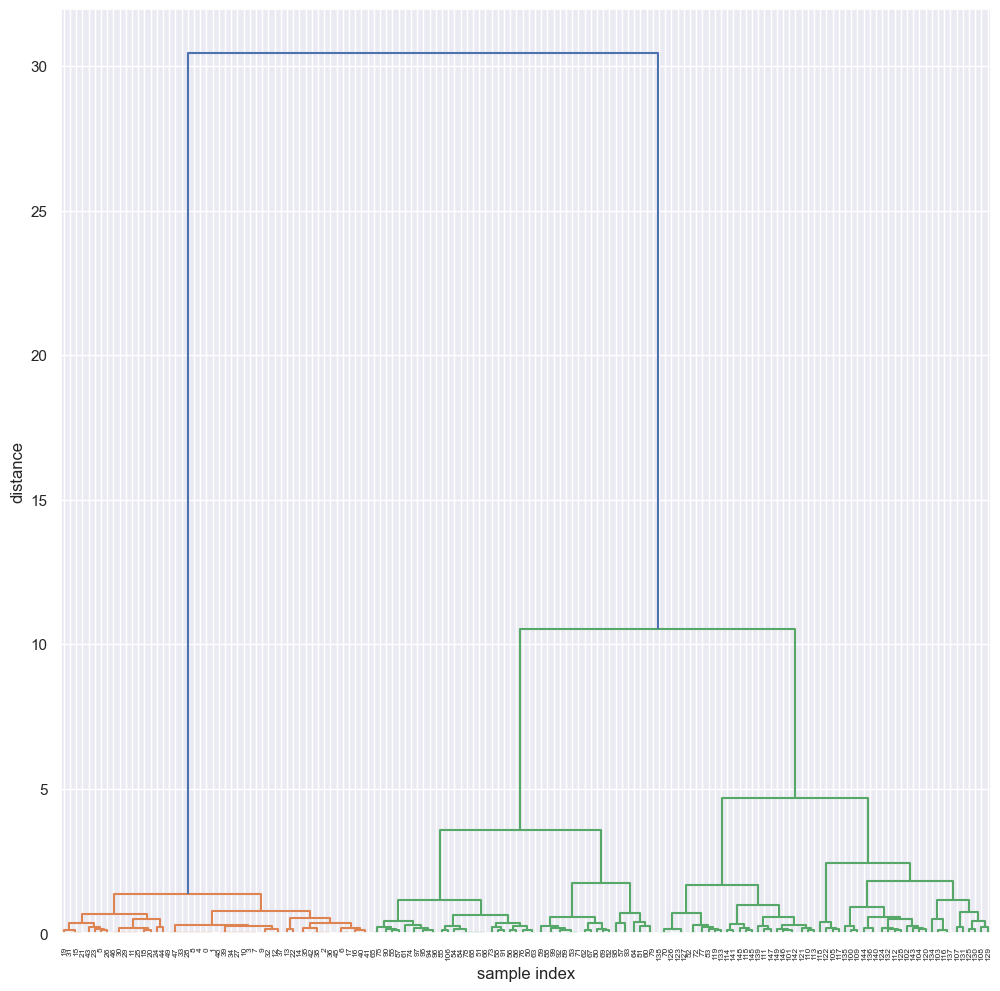

In [36]:
# グラフの大きさを指定
fig = plt.figure(figsize=(12, 12))

# X軸とY軸のラベルを指定
plt.xlabel('sample index')
plt.ylabel('distance')

# デンドログラムの作成
dendrogram(
    Z,
    leaf_rotation=90.,  # X軸のラベルを90度回転させる
    leaf_font_size=6.,  # X軸のラベルのフォントサイズを指定
)
plt.show()

階層型クラスタリングは最終的には1つのクラスタにまとまります。ユーザーはクラスタの途中経過からある程度の段階、今回の例であれば花の品種である3を適切なクラスタ数とし、その結果を利用することとなります。